# Russian Cities Housing Challenge 


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings("ignore")

# Load dataset
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print("Train shape:", train.shape)
print("Test shape:", test.shape)


Train shape: (181507, 279)
Test shape: (77789, 278)


In [8]:
X = train.drop(["price_doc", "id"], axis=1)
y = train["price_doc"]



# Identify numeric & categorical
num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object", "category"]).columns
print("Numerical columns:", len(num_cols))
print("Categorical columns:", len(cat_cols))


Numerical columns: 262
Categorical columns: 15


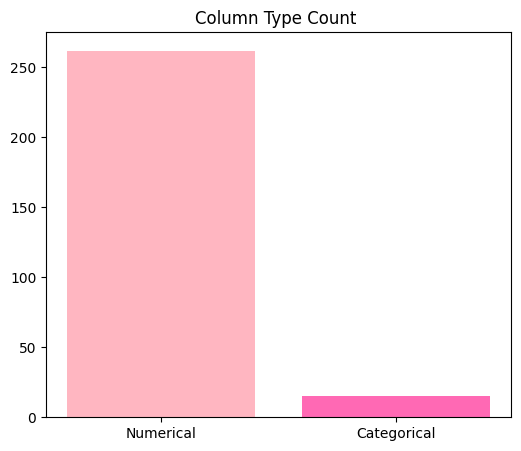

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
plt.bar(['Numerical','Categorical'], [len(num_cols), len(cat_cols)], 
        color=['#ffb6c1','#ff69b4'])
plt.title("Column Type Count ")
plt.show()


Number of columns with missing values: 6

Top 20 columns with missing values:
office_sqm_5000_log            11249
trc_sqm_5000_log                7216
full_all_log                    4023
sport_count_5000_log            2351
area_m_log                        28
raion_popul_log                   13
floor                              0
incineration_raion                 0
office_count_5000                  0
trc_count_5000                     0
cafe_count_5000                    0
cafe_sum_5000_min_price_avg        0
cafe_sum_5000_max_price_avg        0
cafe_avg_price_5000                0
cafe_count_5000_na_price           0
cafe_count_5000_price_500          0
cafe_count_5000_price_1000         0
cafe_count_5000_price_1500         0
cafe_count_5000_price_2500         0
cafe_count_5000_price_4000         0
dtype: int64


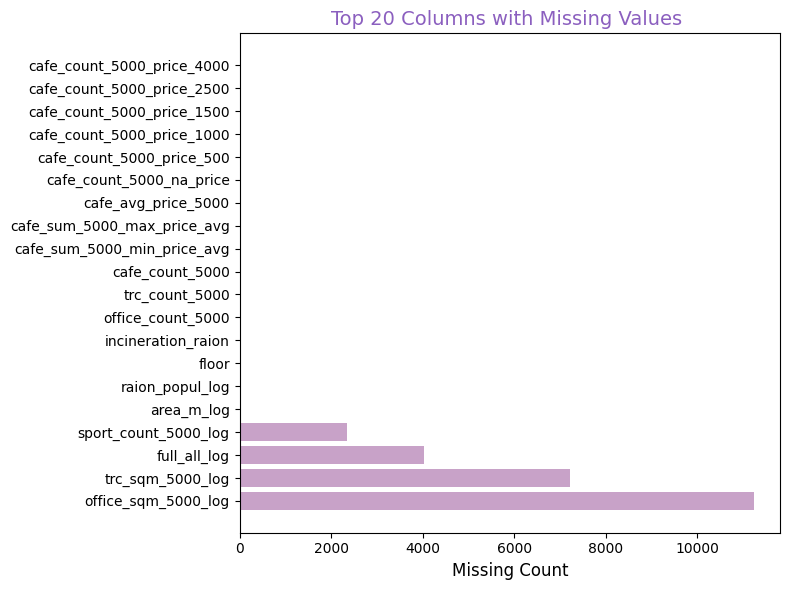


Total missing cells: 24880
Total cells in dataset: 50640453
Overall missing percentage: 0.05%


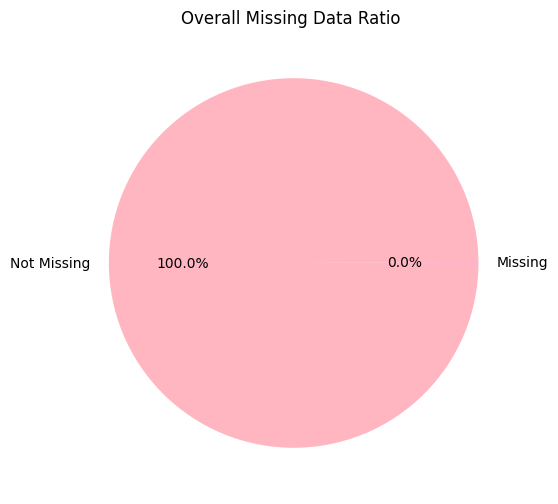

In [10]:
import matplotlib.pyplot as plt


missing_cols_count = (train.isnull().sum() > 0).sum()
print("Number of columns with missing values:", missing_cols_count)

#printing top 20 columns with missing values 
missing = train.isnull().sum().sort_values(ascending=False).head(20)
print("\nTop 20 columns with missing values:")
print(missing)

plt.figure(figsize=(8,6))
plt.barh(missing.index.astype(str), missing.values, color='#c8a2c8')  # lilac
plt.title("Top 20 Columns with Missing Values ", color="#8b5fbf", fontsize=14)
plt.xlabel("Missing Count", fontsize=12)
plt.tight_layout()
plt.show()


total_missing = train.isnull().sum().sum()
total_cells = train.shape[0] * train.shape[1]
missing_ratio = total_missing / total_cells

print("\nTotal missing cells:", total_missing)
print("Total cells in dataset:", total_cells)
print(f"Overall missing percentage: {missing_ratio * 100:.2f}%")


plt.figure(figsize=(6,6))
plt.pie([missing_ratio, 1 - missing_ratio], 
        labels=['Missing','Not Missing'],
        autopct='%1.1f%%',
        colors=['#ff69b4','#ffb6c1'])
plt.title("Overall Missing Data Ratio ")
plt.show()


In [11]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from xgboost import XGBRegressor

X = train.drop(["price_doc", "id"], axis=1)
y = train["price_doc"]


RANDOM_STATE = 29005

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.30, random_state=RANDOM_STATE
)

numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", numeric_pipe, num_cols),
    ("cat", categorical_pipe, cat_cols)
])

def RMSE(model, Xv, yv):
    preds = model.predict(Xv)
    return np.sqrt(mean_squared_error(yv, preds))


In [12]:
def RMSE(model, X_val, y_val):
    pred = model.predict(X_val)
    return np.sqrt(mean_squared_error(y_val, pred))




Running Linear Regression...

 LINEAR REGRESSION RESULTS
RMSE          : 13.6306
Train Time    : 185.070s
Predict Time  : 4.042s


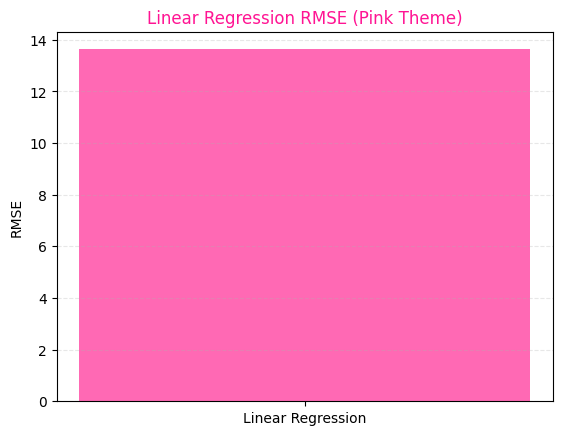

In [ ]:
pipe_lr = Pipeline([
    ("prep", preprocess),
    ("model", LinearRegression())
])

pipe_lr.fit(X_train, y_train)
rmse_lr = RMSE(pipe_lr, X_val, y_val)

print("Linear Regression RMSE:", rmse_lr)
rmse_lr = RMSE(pipe_lr, X_val, y_val)

plt.bar(["Linear Regression"], [rmse_lr], color="#FF69B4")
plt.title("Linear Regression RMSE (Pink Theme)", color="#FF1493")
plt.ylabel("RMSE")
plt.show()



In [ ]:
# Choose a safe small subset of numeric features for polynomial
results = {}

poly_cols = ["full_sq", "life_sq", "floor", "num_room", "kitch_sq"]
poly_cols = [col for col in poly_cols if col in X_train.columns]  # keep only existing

# Pipeline for polynomial
poly_numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures(degree=2, include_bias=False))
])

safe_preprocess_poly = ColumnTransformer([
    ("poly_num", poly_numeric_pipe, poly_cols),
    ("num_rest", numeric_pipe, [c for c in num_cols if c not in poly_cols]),
    ("cat", categorical_pipe, cat_cols)
])

pipe_poly2 = Pipeline([
    ("prep", safe_preprocess_poly),
    ("model", LinearRegression())
])

pipe_poly2.fit(X_train, y_train)
results["Polynomial Degree 2 (safe)"] = RMSE(pipe_poly2, X_val, y_val)

rmse_poly2 = RMSE(pipe_poly2, X_val, y_val)

plt.bar(["Polynomial Deg 2"], [rmse_poly2], color="#FF69B4")
plt.title("Polynomial Degree 2 (Safe Subset)", color="#FF1493")
plt.ylabel("RMSE")
plt.show()




1. Polynomial Degree 2 (Safe Subset, Variance Selection)

Shape after pipeline transform: ()


IndexError: tuple index out of range

Best Ridge Alpha: 100
Best Ridge RMSE: 12.973397643885427


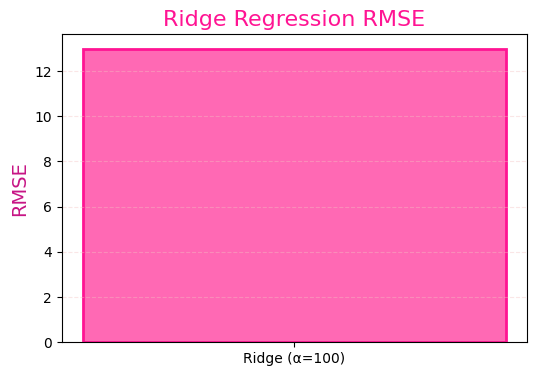

In [16]:
alphas = [0.001, 0.01, 0.1, 1, 10, 100]
ridge_results = {}

for a in alphas:
    model = Pipeline([
        ("prep", preprocess),
        ("model", Ridge(alpha=a))
    ])
    
    model.fit(X_train, y_train)
    ridge_results[a] = RMSE(model, X_val, y_val)

best_alpha = min(ridge_results, key=ridge_results.get)
rmse_ridge = ridge_results[best_alpha]


print("Best Ridge Alpha:", best_alpha)
print("Best Ridge RMSE:", rmse_ridge)

plt.figure(figsize=(6,4))
plt.bar([f"Ridge (α={best_alpha})"], [rmse_ridge],
        color="#FF69B4", edgecolor="#FF1493", linewidth=2)

plt.title("Ridge Regression RMSE", fontsize=16, color="#FF1493")
plt.ylabel("RMSE", fontsize=14, color="#C71585")
plt.grid(axis="y", linestyle="--", color="#F4C2C2", alpha=0.4)
plt.show()


Best Lasso RMSE: 12.985259880131006
Best Lasso Alpha: {'model__alpha': 0.01}


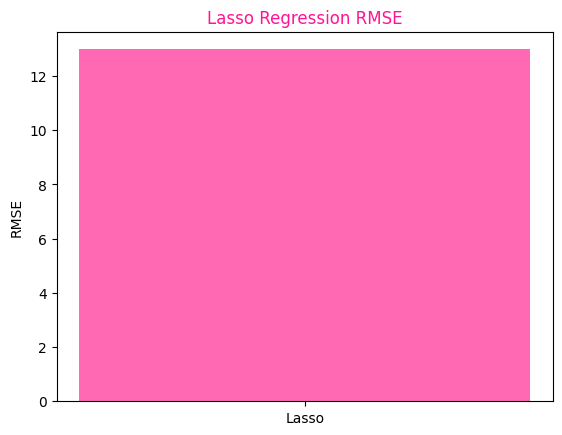

In [ ]:
alpha_grid = {"model__alpha": [0.001, 0.01, 0.1, 1, 10, 100]}

pipe_lasso = Pipeline([
    ("prep", preprocess),
    ("model", Lasso(max_iter=1500))
])

grid_lasso = GridSearchCV(pipe_lasso, alpha_grid, cv=3, scoring="neg_mean_squared_error")
grid_lasso.fit(X_train, y_train)

rmse_lasso = RMSE(grid_lasso.best_estimator_, X_val, y_val)
print("Best Lasso RMSE:", rmse_lasso)
print("Best Lasso Alpha:", grid_lasso.best_params_)

plt.bar(["Lasso"], [rmse_lasso], color="#FF69B4")
plt.title("Lasso Regression RMSE", color="#FF1493")
plt.ylabel("RMSE")
plt.show()


Best ElasticNet RMSE: 12.994327485050833
Best ElasticNet Params: {'model__alpha': 0.001, 'model__l1_ratio': 0.7}


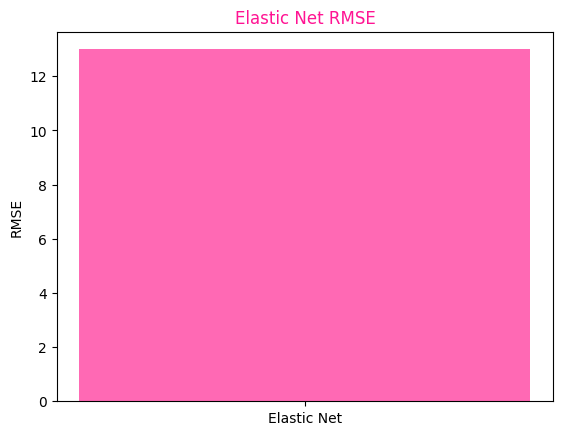

In [12]:
param_en = {
    "model__alpha": [0.001, 0.01, 0.1, 1],
    "model__l1_ratio": [0.1, 0.3, 0.5, 0.7]
}

pipe_en = Pipeline([
    ("prep", preprocess),
    ("model", ElasticNet(max_iter=100))
])

grid_en = GridSearchCV(pipe_en, param_en, cv=3, scoring="neg_mean_squared_error")
grid_en.fit(X_train, y_train)

rmse_en = RMSE(grid_en.best_estimator_, X_val, y_val)
print("Best ElasticNet RMSE:", rmse_en)
print("Best ElasticNet Params:", grid_en.best_params_)
rmse_en = RMSE(grid_en.best_estimator_, X_val, y_val)

plt.bar(["Elastic Net"], [rmse_en], color="#FF69B4")
plt.title("Elastic Net RMSE", color="#FF1493")
plt.ylabel("RMSE")
plt.show()




=== MODEL PERFORMANCE (RMSE) ===
Linear Regression    : 13.63062
Polynomial Deg 2     : 13.62816
Ridge                : 12.97356
Lasso                : 12.98526
Elastic Net          : 12.99433

Best Linear Model RMSE: 12.973558418057527


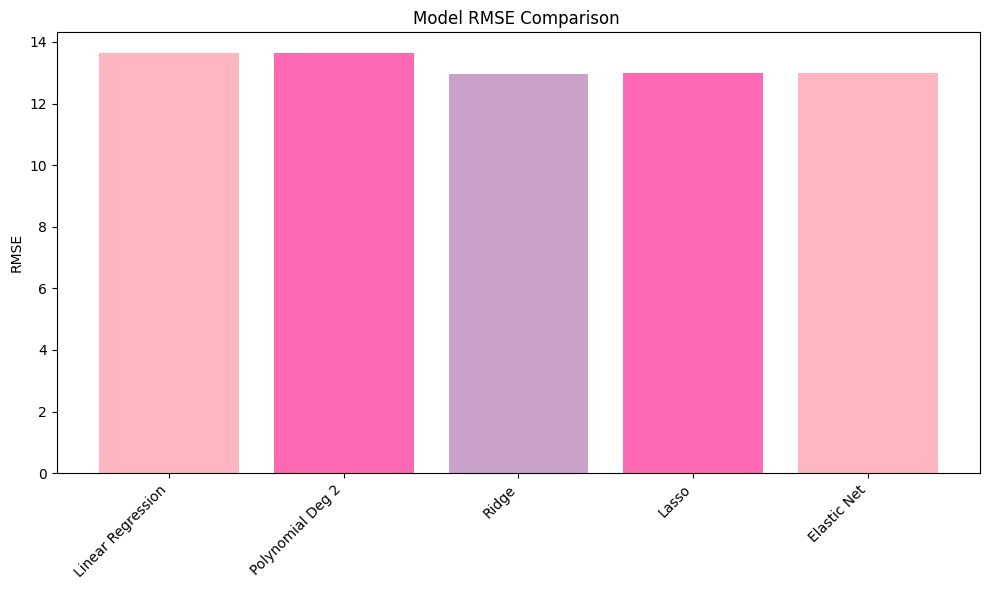

In [ ]:
results = {
    "Linear Regression": rmse_lr,
    "Polynomial Deg 2": rmse_poly2,
    "Ridge": rmse_ridge,
    "Lasso": rmse_lasso,
    "Elastic Net": rmse_en
}


print("\n=== MODEL PERFORMANCE (RMSE)")
for k, v in results.items():
    print(f"{k:20} : {v:.5f}")

best_linear_rmse = min(results.values())
print("\nBest Linear Model RMSE:", best_linear_rmse)
plt.figure(figsize=(10,6))
plt.bar(results.keys(), results.values(), 
        color=['#ffb6c1','#ff69b4','#c8a2c8','#ff69b4','#ffb6c1','#c8a2c8','#ff69b4'])
plt.xticks(rotation=45, ha='right')
plt.ylabel("RMSE")
plt.title("Model RMSE Comparison ")
plt.tight_layout()
plt.show()


In [ ]:
xgb_model = XGBRegressor(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    tree_method="hist",
    n_jobs=-1
)

pipe_xgb = Pipeline([
    ("prep", preprocess),
    ("model", xgb_model)
])

pipe_xgb.fit(X_train, y_train)
rmse_xgb = RMSE(pipe_xgb, X_val, y_val)





print("\n=== FINAL COMPARISON ===")
print("Best Linear Model RMSE:", best_linear_rmse)
print("XGBoost RMSE:", rmse_xgb)



=== FINAL COMPARISON ===
Best Linear Model RMSE: 12.973558418057527
XGBoost RMSE: 12.83779217442415
